Trial 30 Complete [00h 04m 25s]
val_loss: 0.017538025975227356

Best val_loss So Far: 0.0032842729706317186
Total elapsed time: 01h 09m 33s
Epoch 1/50


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 17 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - custom_mae: 0.0825 - custom_mape: 89382.2500 - custom_rmse: 0.1060 - loss: 0.0029 - val_custom_mae: 0.0940 - val_custom_mape: 29.3341 - val_custom_rmse: 0.1090 - val_loss: 0.0036
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - custom_mae: 0.0789 - custom_mape: 252620.5312 - custom_rmse: 0.1010 - loss: 0.0025 - val_custom_mae: 0.0829 - val_custom_mape: 25.3757 - val_custom_rmse: 0.0994 - val_loss: 0.0028
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - custom_mae: 0.0794 - custom_mape: 79353.9922 - custom_rmse: 0.1020 - loss: 0.0025 - val_custom_mae: 0.0912 - val_custom_mape: 28.6084 - val_custom_rmse: 0.1091 - val_loss: 0.0036
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - custom_mae: 0.0786 - custom_mape: 118531.6328 - custom_rmse: 0.1016 - loss: 0.0025 - val_custom_mae: 0.0921 - val_custom_mape: 28.5014 - val_custom_rmse: 0.1103 - val_loss: 0.0036
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - custom_mae: 0

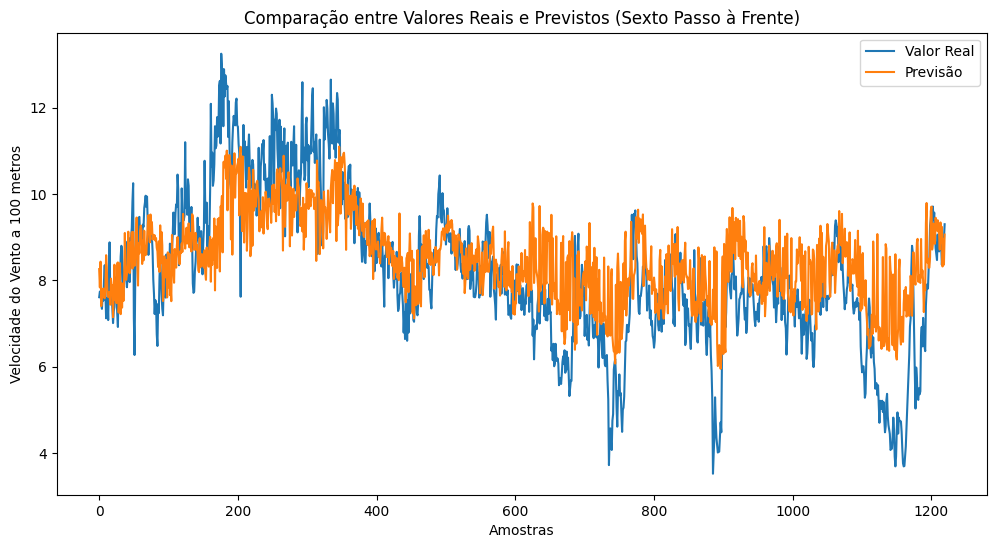

In [15]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, LSTM, Bidirectional,
    Concatenate, Attention, Reshape
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperParameters, Hyperband
import os

# Carregar dados
data = pd.read_csv("dataset.csv")

# Converter 'id' em datetime e definir como índice
data['timestamp'] = pd.to_datetime(data['id'], errors='coerce')
data.set_index('timestamp', inplace=True)

# Selecionar variáveis
variables = data[['ws100', 'humid', 'wdisp100', 'hour', 'wdir100']]

# Remover valores ausentes
variables = variables.dropna()

# Padronização dos dados usando MinMaxScaler
scaler = MinMaxScaler()
variables_scaled = scaler.fit_transform(variables)

# Parâmetros
sequence_length = 288  # janela de aprendizado de 36
pred_step = 6  # Previsão do sexto passo à frente
split_ratio = 0.8  # 80% treinamento, 20% teste

# Divisão dos dados em treinamento e teste
split_index = int(len(variables_scaled) * split_ratio)
train_data = variables_scaled[:split_index]
test_data = variables_scaled[split_index:]

# Função para preparar sequências de dados
def create_sequences(data, seq_length, pred_step):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_step + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length+pred_step-1, 0])  # ws100 no sexto passo à frente
    return np.array(X), np.array(y)

# Criar sequências para treinamento e teste
X_train, y_train = create_sequences(train_data, sequence_length, pred_step)
X_test, y_test = create_sequences(test_data, sequence_length, pred_step)

# Ajustar as formas de y_train e y_test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Valores mínimos e máximos de 'ws100' para inversão da escala
ws100_min = scaler.data_min_[0]
ws100_max = scaler.data_max_[0]

# Definição de métricas customizadas (se necessário)
def custom_mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def custom_rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def custom_mape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    return tf.reduce_mean(tf.abs((y_true - y_pred) / tf.maximum(tf.abs(y_true), epsilon))) * 100

custom_objects = {
    'custom_mae': custom_mae,
    'custom_rmse': custom_rmse,
    'custom_mape': custom_mape
}

# %% [markdown]
# Definição de funções de perdas customizadas.

# %%
# Calcular a distribuição das velocidades do vento no conjunto de treinamento
ws100_train = train_data[:, 0]  # ws100 é a primeira coluna
hist, bin_edges = np.histogram(ws100_train, bins=100)

# Calcular a frequência inversa para cada bin
freq = hist / np.sum(hist)
weights = 1 / (freq + 1e-6)  # Adicionar um pequeno valor para evitar divisão por zero
weights = weights / np.max(weights)  # Normalizar pesos para que o máximo seja 1

# Função para obter o peso de acordo com o valor de ws100
def get_weight(value):
    # Encontrar o bin correspondente ao valor
    bin_index = np.searchsorted(bin_edges, value) - 1
    bin_index = np.clip(bin_index, 0, len(weights) - 1)
    return weights[bin_index]

# Função de perda personalizada com pesos baseados na distribuição
def custom_distribution_weighted_mse(y_true, y_pred):
    # Obter os pesos para y_true
    weights_vector = tf.numpy_function(get_weight, [y_true], tf.float64)
    weights_vector = tf.cast(weights_vector, tf.float32)
    # Calcular o erro quadrático ponderado
    loss = tf.reduce_mean(weights_vector * tf.square(y_true - y_pred))
    return loss

def custom_log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true + 1e-12)))

def custom_higher_power_mae(y_true, y_pred):
    power = 3  # Ajuste para 3 ou 4 conforme necessário
    loss = tf.reduce_mean(tf.pow(tf.abs(y_true - y_pred), power))
    return loss

def custom_msle(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true_clipped = tf.clip_by_value(y_true, epsilon, None)
    y_pred_clipped = tf.clip_by_value(y_pred, epsilon, None)
    first_log = tf.math.log(y_true_clipped + 1.0)
    second_log = tf.math.log(y_pred_clipped + 1.0)
    loss = tf.reduce_mean(tf.square(first_log - second_log))
    return loss

def custom_huber_loss(y_true, y_pred):
    delta = 0.1  # Delta pequeno
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic
    loss = tf.reduce_mean(0.5 * tf.square(quadratic) + delta * linear)
    return loss

def custom_exponential_error(y_true, y_pred):
    loss = tf.reduce_mean(tf.exp(tf.abs(y_true - y_pred)))
    return loss

# Atualizar o dicionário custom_objects
custom_objects.update({
    'custom_distribution_weighted_mse': custom_distribution_weighted_mse,
    'custom_log_cosh_loss': custom_log_cosh_loss,
    'custom_higher_power_mae': custom_higher_power_mae,
    'custom_msle': custom_msle,
    'custom_huber_loss': custom_huber_loss,
    'custom_exponential_error': custom_exponential_error
})

# %% [markdown]
# Geração do modelo usando LSTM bidirecional

# %%
def build_model_bidirectional_seq2seq_with_attention(hp):
    units = hp.Int('units', min_value=64, max_value=256, step=32)
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3])
    dropout_rate = 0.3 
    num_layers = hp.Int('layers', min_value=1, max_value=2, step=1)
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    loss_choice = hp.Choice('loss_function', values=[
        'custom_distribution_weighted_mse',
        'custom_higher_power_mae',
        'custom_log_cosh_loss',
        'custom_msle',
        'custom_huber_loss',
        'custom_exponential_error'
    ])
    
    loss_functions = {
        'custom_distribution_weighted_mse': custom_distribution_weighted_mse,
        'custom_higher_power_mae': custom_higher_power_mae,
        'custom_log_cosh_loss': custom_log_cosh_loss,
        'custom_msle': custom_msle,
        'custom_huber_loss': custom_huber_loss,
        'custom_exponential_error': custom_exponential_error
    }
    selected_loss = loss_functions[loss_choice]
    
    # Seleção do Otimizador
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    num_features = X_train.shape[2]
    
    # Encoder
    encoder_inputs = Input(shape=(sequence_length, num_features), name='encoder_inputs')
    encoder_outputs = encoder_inputs
    for i in range(num_layers):
        encoder_outputs = Bidirectional(LSTM(
            units=units,
            return_sequences=True,
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'encoder_lstm_{i}'
        ))(encoder_outputs)
        encoder_outputs = LayerNormalization(name=f'encoder_norm_{i}')(encoder_outputs)
    
    # Contexto de Atenção
    context_vector = encoder_outputs  # Usaremos as saídas do encoder para a atenção
    
    # Decoder
    decoder_inputs = encoder_outputs[:, -1, :]  # Usar o último passo do encoder
    decoder_inputs = Reshape((1, units * 2))(decoder_inputs)  # units*2 devido bidirectional
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        decoder_outputs = LSTM(
            units=units * 2,
            return_sequences=True,
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'decoder_lstm_{i}'
        )(decoder_outputs)
        decoder_outputs = LayerNormalization(name=f'decoder_norm_{i}')(decoder_outputs)
    
    # Aplicar Atenção
    attention_output = Attention(name='attention_layer')([decoder_outputs, context_vector])
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_output])
    
    # Camada de Saída
    outputs = Dense(1, activation='linear', name='output_layer')(decoder_combined_context[:, 0, :])
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Bidirectional_LSTM_with_Attention')
    
    # Compilação do Modelo com a Função de Perda Selecionada
    model.compile(
        optimizer=optimizer,
        loss=custom_higher_power_mae,
        metrics=[
            custom_mae,
            custom_rmse,
            custom_mape        
        ]
    )
    
    return model

# %% [markdown]
# Hypertuning do modelo para gerar os melhores parâmetros

# %%
# Definir o tuner para a primeira etapa de treinamento
tuner_stage1 = Hyperband(
    build_model_bidirectional_seq2seq_with_attention,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='tuner_dir_stage1',
    project_name='wind_speed_prediction_stage1'
)

early_stopping_stage1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Primeira Etapa de Treinamento
tuner_stage1.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_stage1],
    verbose=1  # Habilitar verbosidade para monitorar o processo
)

# Obter o melhor modelo da primeira etapa
best_model_stage1 = tuner_stage1.get_best_models(num_models=1)[0]

# Salvar o modelo da primeira etapa
model_save_path_stage1 = 'best_model_stage1.h5.keras'
best_model_stage1.save(model_save_path_stage1)

# Segunda Etapa de Treinamento (Fine-tuning)
# Carregar o modelo da primeira etapa
model_finetune = load_model(model_save_path_stage1, custom_objects=custom_objects)

# Compilar o modelo com a nova função de perda ponderada
model_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=custom_higher_power_mae,
    metrics=[
        custom_mae,
        custom_rmse,
        custom_mape        
    ]
)

# Treinar o modelo na segunda etapa
early_stopping_stage2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_finetune = model_finetune.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_stage2]
)

# Salvar o modelo final
model_save_path_final = 'best_model_final.h5.keras'
model_finetune.save(model_save_path_final)

# %% [markdown]
# Avaliação e plotagem dos gráficos.

# %%
# Carregar o modelo final
loaded_model = load_model(model_save_path_final, custom_objects=custom_objects)

# Avaliação no conjunto de teste
y_pred = loaded_model.predict(X_test)

# Inversão da padronização
y_pred_inv = y_pred * (ws100_max - ws100_min) + ws100_min
y_test_inv = y_test * (ws100_max - ws100_min) + ws100_min

# Avaliação das métricas
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / np.maximum(y_test_inv, 1e-6))) * 100  # Evitar divisão por zero

print("Desempenho no Conjunto de Teste:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%\n")

# Plotagem das previsões
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Valor Real')
plt.plot(y_pred_inv, label='Previsão')
plt.legend()
plt.title('Comparação entre Valores Reais e Previstos (Sexto Passo à Frente)')
plt.xlabel('Amostras')
plt.ylabel('Velocidade do Vento a 100 metros')
plt.show()
